# Implementation and Expermientation on the DE algorithm


## Setting up the test problem

To begin with we'll need to implement the necesarry modules to be used in this implementation of the differential evolution algorithm.

In [13]:
import numpy as np
import matplotlib.pyplot as plt

Next we'll define and set the parameters for a test problem. In the case of this implementation I have decided to use the Vehicle Routing problem (VRP).

In [19]:
# # Define problem parameters
NUM_CUSTOMERS = 5 # Number of customers minus the depot
NUM_VEHICLES = 3
CAPACITY = 9
DE_POPULATION_SIZE = 3
DE_MAX_GENERATIONS = 20
DE_CR = 0.5
DE_F = 0.5

An important aspect of the VRP, is the customer demands. This parameter dictates what each cutomer needs and decides whether a vehicle traveling on that route can meet those needs. 

This parameter is set randomly at the start of the problem. To begin with for continuity purposes the seed of the random number generator is given a set value, however, later when testing this seed will not be set.

In [20]:
# # Generate random customer demands
np.random.seed(42)
customer_demands = np.random.randint(1, 3, size=NUM_CUSTOMERS)
customer_demands = np.concatenate(([0], customer_demands))
print('Customer Demands: ', customer_demands)

Customer Demands:  [0 1 2 1 1 1]


The next step when setting up the VRP is to generate an array of locations and distances between those locations.
<br>The number of locations is equal to the number of customers +1 to include the depot where the vehicles start.
<br><font color='red'>Note: The vehicle depot has a cutomer demand of 0</font>
<br>This is represented as index 0 in the locations array.
<br>The locations are implemented as and array of 2 dimensional coordinates with values between 0 and 1.
<br>The distances are stored as $n \times n$ array where the values are calculated as the euclidean distance between all locations and $n$ is the number of customers +1.

In [21]:
# # Define distance matrix
locations = np.random.rand(NUM_CUSTOMERS + 1, 2)
distances = np.zeros((NUM_CUSTOMERS + 1, NUM_CUSTOMERS + 1))
for i in range(NUM_CUSTOMERS + 1):
    for j in range(i + 1, NUM_CUSTOMERS + 1):
        distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        distances[j, i] = distances[i, j]

This function checks if any of the contraints of the CVRP have been broken and return the amount.

In [22]:
def check_validity(trial_solution, customer_demands):
    valid_solution = 0
    start_position = 0
    temp = trial_solution[trial_solution != 0].copy()
    unique = np.unique(temp)
    if len(unique) != len(temp):
        # # Makes sure all customer IDs are unique
        valid_solution += 1
    elif trial_solution.max() > NUM_CUSTOMERS:
        # # Makes sure the largest customer ID is no larger the the total number of customers
        valid_solution += 1
    elif trial_solution.min() < 0:
        # # Makes sure the largest customer ID is greater than 0
        valid_solution += 1
    else: 
        for _ in range(NUM_VEHICLES):
            route_start = None
            route_end = None
            count = 0
            for l in range(start_position, NUM_CUSTOMERS + NUM_VEHICLES + 1):
                if trial_solution[l] == 0 and route_start is None:
                    route_start = l
                elif trial_solution[l] == 0 and route_start is not None:
                    route_end = l
                    break
                else:
                    count += 1
            if route_start is None or route_end is None or count == 0:
                # # Makes sure there is a start and end to each route and each vehicle
                # # visits at least 1 customer
                valid_solution += 1
            route = trial_solution[route_start:route_end+1]
            if np.sum(np.fromiter([customer_demands[i] for i in route[route != 0]], float)) > CAPACITY:
                # # Makes sure the total customer demand for a route isn't greater than the capacity
                # # of a vehicle.
                valid_solution += 1
            start_position = route_end
        if start_position != len(trial_solution) - 1:
            # # Makes sure that the final vehicle return to the depot
            valid_solution += 1
    return valid_solution

The final step when defining the test problem is to build a fitness fuction for the problem.
<br>The first step to doing this is to consider what a solution to the VRP will look like.
<br> In my implementation I decided to store a solution as 1 dimmensional array, where the value '0' dictates the start and end of a vehicles route.
<br> Our fitness function then needs to take in this array, split it up into its seperate routes and calculate the distance of each route.
<br> Finally we sum the distance of all the routes to get the total distance travelled by the vehicles and use that as the fitness value.

<br><br> The fitness function also uses the check_validity function to apply a penalty to the fitness if the solution isn't valid. This helps to relax the search space and allows the algorithm to accept invalid solutions providing they are better than the current one. 
<br> When determing the value of the penalty, I originally just added the weight of all the edges together to guarantee the penalty would be worse than any valid solution. I found this made the search space quite rugged as there was a very large difference between solutions that only broke a single constraint and valid solutions. I have also  been working on the TSP recently and found that a good penalty for routing problems is calculated as $$\frac{\text{sum of distances} * \text{total nodes}}{\text{total edges}}$$. I then multiplied this penalty by the number of constraints found to be broken in the check_validity function.

In [23]:
# # Define fitness function
def fitness(solution, distances, customer_demands):
    """
    Computes the total distance traveled by all vehicles in the solution, given a list of routes.
    """
    total_distance = 0
    routes = np.split(solution, np.where(solution == 0)[0])
    routes = [r for r in routes if len(r) > 0]
    # total_distance = 0
    for r in routes:
        r = np.concatenate((r, [0]))
        route_distance = 0
        # print(r)
        for i in range(len(r) - 1):
            if r[i] < len(distances) and r[i] >= 0 and r[i+1] < len(distances) and r[i+1] >= 0:
                route_distance += distances[r[i]][r[i + 1]]
        total_distance += route_distance

    # # Check validity of solution
    valid_solution = check_validity(solution, customer_demands)
    total_distance += ((np.sum(distances) * len(distances)) / np.count_nonzero(distances)) * valid_solution

    return total_distance

We can test the fitness function by giving it a dummy solution.
<br>Using the test problem above we can create a solution such as [0, 5, 1, 0, 2, 0, 4, 3, 0].
<br>This indicates that vehicle 1 visits locations 5 and 1, vehicle 2 visits location 2 and vehicle 3 visits locations 4 and 3.
<br>Using the graph above we can roughly calculate that this will cost a total distance of roughly 4.02.
<br>This is confirmed by running the code below.

In [24]:
solution = np.array([0, 5, 1, 0, 2, 0, 4, 3, 0])
total_distance = fitness(solution, distances, customer_demands)
print('The total distance is: ', total_distance)

The total distance is:  4.032467178463161


## Implementation of the algorithm

The first step to implementing the algorithm was to think about what parameters the DE function needed to take.
<br> This came down to the fitness function "fitness_fn". The reason for this is that if we wanted to change the problem the DE algorithm was solving we could simply pass in a different fitness function. This leads to flexibility, modularity and reuseability within the code.
<br><br> The next step was to generate the initial population for the algorithm. Since we've used a direct problem encoding there are a few parameters to each solution that are a given. Firstly, all the customers must be visited in the solution only once. This is generated by creating an array with a range of all the customer ID's. Secondly, there must be NUM_VEHICLES - 1 number of 0s in the solution to represent each vehicle starting their journey. These are added to the end of the customer ID array we created previously. Thirdly, we want each solution to be in a random order so we use numpys shuffle function to mix each solution up. Finally there must be a 0 on each end of the solution, indicating that the first vehicle must start a route and the last vehicle must end one. Therefore if there's only one vehicle it must start and finish its journey.

In [25]:
def generate_population(population_size):
    # # Generate random population, where each individual is a list of customer IDs
    # # This initial population does not include the depot (customer 0)
    # # population = np.random.randint(1, NUM_CUSTOMERS, size=(population_size, NUM_CUSTOMERS))
    population = np.zeros((population_size, NUM_CUSTOMERS), dtype=int)
    for i in range(population_size):
        population[i] = np.arange(1, NUM_CUSTOMERS + 1)

    # # Add the number of returns to the depot so the specified number of vehicles is used
    vehicles = np.zeros((population_size, NUM_VEHICLES - 1), dtype=int)
    population = np.concatenate((population, vehicles), axis=1)

    # # Shuffle the location where each vehicle returns to the depot
    for solution in population:
        solution = np.random.shuffle(solution)
    zeros = np.zeros((population_size, 1), dtype=int)

    # # Add the depot to the beginning and end of each solution
    population = np.concatenate((population, zeros), axis=1)
    population = np.concatenate((zeros, population), axis=1)

    return population

The next step in implementing the DE algorithm is to create the mutation function. In DE both mutation and crossover are performed. Mutation is done on each node to make a new solution and then random nodes from that solution are chosen, based on the CR value, to crossover with the initial solution to produce the final trial solution. Since the mutation operation can be performed on each value of the solution seperatly it's possible to combine the mutation and crossover steps so that only after the node has been chosen. This is the method used in my fitness function implementation.
<br> Since I used a direct encoding of the CVRP, we have to make sure the mutation operation maintains the integrity when producing the trial solution. In this case, that means we need to make sure all the customer IDs are included in the trial solution and are unique, there is NUM_VEHICLES-1 0s in the main body of the solution and finally there is a 0 on each end.
<br> To maintain this I needed to change the way DE worked slightly so that instead of changing the value of the selected node according to: $$v_{i,G+1} = x_{r1,G} + F \cdot (x_{r2,G}-x_{r3,G})$$ I instead use the value of $v_{i,G+1}$ to select an index from the current population solution to perform a swap function on. By also making sure that each node can only be swapped once, I can maintain the integrity of the trial solution, while still generating a new solution.
<br> To make sure the 0 values on each end of the solution were not affected, I remove them before the mutation and then add them back at the end.
<br><br> It should also be noted that to ensure crossover happens at least once, as per the original algorithm design, a random point in the solution is selected which is guaranteed to be crossed over. This is labelled chosen in the function below.

In [26]:
def perform_mutation(population, population_size, current_idx, f, crossover_rate):
    # # Select three random individuals from the population
    a_idx, b_idx, c_idx = np.random.choice(population_size, size=3, replace=False)
    a, b, c = population[a_idx], population[b_idx], population[c_idx]

    # # Select current population member
    current_pop = population[current_idx].copy()
    current_pop = np.delete(current_pop, [0])
    current_pop = np.delete(current_pop, [-1])

    # # Set up trial solution
    trial_solution = np.zeros(len(current_pop), dtype=int)

    # # Perform crossover operation
    chosen = np.random.randint(NUM_CUSTOMERS + NUM_VEHICLES - 2)
    values = np.arange(NUM_CUSTOMERS + NUM_VEHICLES - 2)
    count = 0
    swapped = []
    for k in range(len(current_pop)):
        if k not in swapped:
            if np.random.rand() <= crossover_rate or k == chosen:
                if len(values) != 0:
                    value_index = int((a[k] + f * (b[k] - c[k])) % (len(values)))
                else:
                    break
                swap_index = values[value_index]
                trial_solution[k] = current_pop[swap_index]
                trial_solution[swap_index] = current_pop[k]
                swapped.append(swap_index)
                swapped.append(k)
                values = np.delete(values, value_index)
                values = np.delete(values, np.where(values == k))
            else:
                trial_solution[k] = current_pop[k]

    trial_solution = np.concatenate(([0], trial_solution))
    trial_solution = np.concatenate((trial_solution, [0]))
    return trial_solution

Next we need to produce a selection function to decide whether a trial solution is accepted or not. In the original paper the selection is done via a greedy method so that is also the version I've implemented. I did also try a version where duplicate solutions were not allowed in the population, to prevent the algorithm from getting stuck in local optima. However, due to the number of ways a single vector could be mutated this proved unecessary.

In [27]:
def update_population(population, current_idx, trial_solution, trial_fitness, best_fitness, best_solution, fitness_fn, distances, customer_demands):
    # # Update population with trial solution if it is better
    if trial_fitness < fitness_fn(population[current_idx], distances, customer_demands):
        population[current_idx] = trial_solution
        if trial_fitness < best_fitness:
            best_fitness = trial_fitness
            best_solution = trial_solution
    return population, best_fitness, best_solution

Finally we create the differential evolution function itself. This function is relatively simple as we've split the components of the DE into their own functions.
<br> The first step in this function generates the initial population and then calculates best fitness value of that population. 
<br> Next the process of creating a trial solution, calculating its fitness and performing selection is repeated for every solution in the population. 
<br> This is again repreated for however many generations were selected and the best solution found is returned.

In [28]:
def differential_evolution(fitness_fn, population_size, max_generations, crossover_rate, f, customer_demands, distances, print_iter = 0, output = False):
    # # Initialize population
    population = generate_population(population_size)

    best_fitness = np.inf
    for solution in population:
        fitness = fitness_fn(solution, distances, customer_demands)
        if fitness < best_fitness:
            best_fitness = fitness
            best_solution = solution
            
    fitness_history = []
    for i in range(max_generations):
        for j in range(population_size):
            # # Perform mutation and crossover
            trial_solution = perform_mutation(population.copy(), population_size, j, f, crossover_rate)

            trial_fitness = fitness_fn(trial_solution, distances, customer_demands)
                
            # # Update population with trial solution if it is better
            population, best_fitness, best_solution = update_population(population, j, trial_solution, trial_fitness, best_fitness, best_solution, fitness_fn, distances, customer_demands)
        
        fitness_history.append(best_fitness)
        if output:
            if i % 10**print_iter == 0:
                print(f"Generation {i + 1}/{max_generations}: Best fitness = {best_fitness}")

    return best_solution, best_fitness, fitness_history


Finally we can run the DE algorithm for the test problem and plot the change in the fitness value with each iteration.

Generation 1/20: Best fitness = 5.189338084083714
Generation 2/20: Best fitness = 5.189338084083714
Generation 3/20: Best fitness = 5.189338084083714
Generation 4/20: Best fitness = 5.189338084083714
Generation 5/20: Best fitness = 5.189338084083714
Generation 6/20: Best fitness = 4.949616532635275
Generation 7/20: Best fitness = 4.704503035594496
Generation 8/20: Best fitness = 4.704503035594496
Generation 9/20: Best fitness = 3.966216947828759
Generation 10/20: Best fitness = 3.966216947828759
Generation 11/20: Best fitness = 3.966216947828759
Generation 12/20: Best fitness = 3.966216947828759
Generation 13/20: Best fitness = 3.966216947828759
Generation 14/20: Best fitness = 3.966216947828759
Generation 15/20: Best fitness = 3.966216947828759
Generation 16/20: Best fitness = 3.966216947828759
Generation 17/20: Best fitness = 3.966216947828759
Generation 18/20: Best fitness = 3.966216947828759
Generation 19/20: Best fitness = 3.966216947828759
Generation 20/20: Best fitness = 3.96621

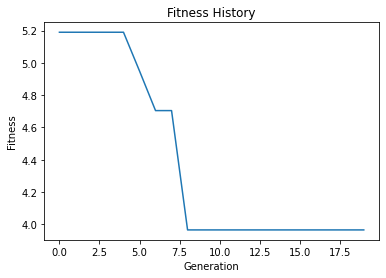

In [29]:

# # Run Differential Evolution algorithm
best_solution, best_fitness, fitness_history = differential_evolution(
    fitness_fn=fitness,
    population_size=DE_POPULATION_SIZE,
    max_generations=DE_MAX_GENERATIONS,
    crossover_rate=DE_CR,
    f=DE_F,
    customer_demands=customer_demands,
    distances=distances,
    output = True
)
    
# # Print best solution and fitness
print(f"Best solution: {best_solution}")
print(f"Best fitness: {best_fitness}")

# # Visualize fitness history
plt.plot(fitness_history)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness History")
plt.show()

## Graphing The Solution

To visualize the solution I created a function to draw each route on the original graph in a different colour.

In [30]:
import matplotlib as mpl
from matplotlib.patches import Patch

def plot_cvrp_solution(locations, solution):
    
    # # Define a color map to use for the routes
    cmap = mpl.colormaps['hsv']

    # # Create a dictionary to store the colors for each route
    color_dict = {}
    
    # # Create a plot and set the plot size
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # # Plot the customer locations
    ax.scatter([loc[0] for loc in locations], [loc[1] for loc in locations], s=100, color='black')

    # # Get the solution vehicle routes
    routes = np.split(solution, np.where(solution == 0)[0])
    routes.pop(0)
    routes.pop(-1)
    
    # # Plot the solution routes
    for i in range(len(routes)):
        route = routes[i]
        route = np.concatenate((route, [0]))

        color = cmap(i / len(routes))
        
        # # Create a line plot for the route
        ax.plot([locations[x][0] for x in route], [locations[x][1] for x in route], color=color, linewidth=3, label=f'Vehicle {i}')

        color_dict[f"Route {i}"] = color
        
    
    # # Set the axis limits and labels
    ax.set_xlim([0, max([loc[0] for loc in locations]) * 1.1])
    ax.set_ylim([0, max([loc[1] for loc in locations]) * 1.1])
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    
    # # Set the title
    ax.set_title(f'CVRP Solution ({NUM_VEHICLES} Vehicles, Capacity {CAPACITY})')

    # # Create a legend for the solution routes
    legend_handles = [Patch(facecolor=color_dict[label], label=label) for label in color_dict.keys()]

    # # Define the coordinates for the legend box
    legend_x = 1
    legend_y = 0.5
    
    # # Place the legend box outside of the graph area
    plt.legend(handles=legend_handles, bbox_to_anchor=(legend_x, legend_y), loc='center left', title='Routes')
    
    # # Show the plot
    plt.show()

Running this function we get the graphical representation of the solution we found to the previous problem.

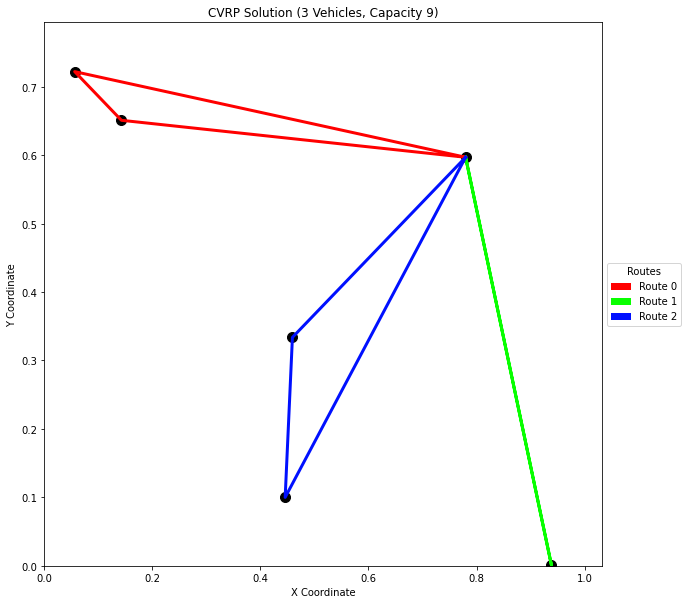

In [31]:
# # Plot graph with solution
plot_cvrp_solution(locations, best_solution)

## Testing

After looking through the literature I found two datasets often used for CVRP instances when solving using DE type algorithms. These can both be found in CVRPLIB. The first dataset is "Set A (Augerat, 1995)" and the second dataset is "Set P (Augerat, 1995)".
<br> To download and intepret these datasets I used the vrplib python module. I've included all instances used along side this notebook so the following function can be used to load them in. I should also note that not all CVRP problems on CVRPLIB have coordinates so if that is not the case the coordinates are randomly generated. Doing this won't affect the solution but the graph edge weights won't directly correspond to the length of the edge.
<br><br> Below I've imported and solved the "A-n32-k5" instance using the DE to give an example of how this works.

Also since external libraries are not allowed, I used the vrplib python library to download and convert the instances to dictionaries which I'm now reading in using pythons standard pickle library.

Generation 1/3000: Best fitness = 3835.645161290323
Generation 1001/3000: Best fitness = 1330.0
Generation 2001/3000: Best fitness = 1204.0
Best solution: [ 0 24  6 18  4 31 21  0 14  3 17 19 23 28  0  5 25 10 15  9 22 29 20  0
 26  8 11  2 13  1 12  0 30 16  7 27  0]
Best fitness: 1163.0


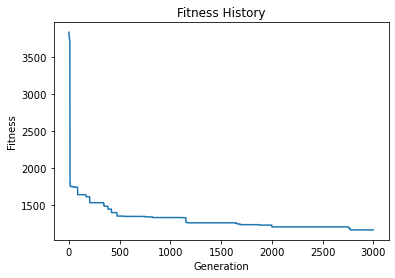

In [32]:
import pickle

instance_name = "A-n32-k5"
with open("./cvrp_instances/" + instance_name + ".pkl", 'rb') as file:
    instance = pickle.load(file)
with open("./cvrp_solutions/" + instance_name + ".pkl", 'rb') as file:
    global_solution = pickle.load(file)

NUM_CUSTOMERS = instance['dimension'] - 1
NUM_VEHICLES = int(instance_name.split('k')[1])
CAPACITY = instance['capacity']
DE_POPULATION_SIZE = 10
DE_MAX_GENERATIONS = 3000
DE_CR = 0.1
DE_F = 0.7

if 'node_coord' in instance:
    locations = instance['node_coord']
else:
    locations = np.random.rand(NUM_CUSTOMERS + 1, 2)
    
customer_demands = instance['demand']
distances = np.rint(instance['edge_weight'])

# # Run Differential Evolution algorithm
best_solution, best_fitness, fitness_history = differential_evolution(
    fitness_fn=fitness,
    population_size=DE_POPULATION_SIZE,
    max_generations=DE_MAX_GENERATIONS,
    crossover_rate=DE_CR,
    f=DE_F,
    customer_demands=customer_demands,
    distances=distances,
    print_iter = 3,
    output = True
)
    
# # Print best solution and fitness
print(f"Best solution: {best_solution}")
print(f"Best fitness: {best_fitness}")

# # Visualize fitness history
plt.plot(fitness_history)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness History")
plt.show()

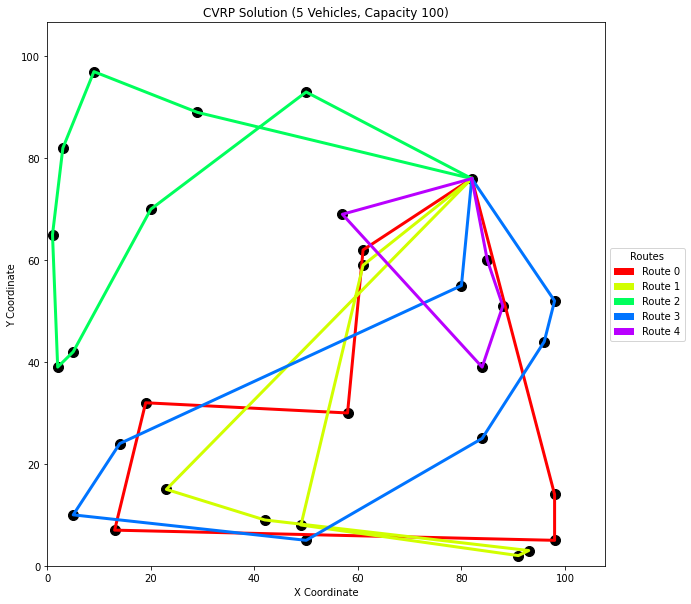

In [33]:
# # Plot graph with solution
plot_cvrp_solution(locations, best_solution)

## Testing Parameters

One of the most important parts of testing an algorithm is determing which parameters work best for it. 
In the case of the DE this tends to be relatively simple since it only accepts 2 parameters, CR and F.
I therefore set up and ran the following tests on the "P-n16-k8" problem, as its a bit smaller. 


### Experiment 1

The first test involoved below involves running the algorithm for different values of CR.
CR must be between 0 and 1 and based on a few preliminary tests I found it to work best the smaller the value. I, therefore, decided to test the values 0, 0.1, 0.2, 0.25, 0.5, 0.75 and 1. Each of these tests was conducted 4 times and the average was calculated. The population size was equal to $\text{dimension}$. The number of generations was 3000.

In [34]:
from datetime import datetime
import pandas as pd
import os

instance_name = "P-n16-k8"
with open("./cvrp_instances/" + instance_name + ".pkl", 'rb') as file:
    instance = pickle.load(file)
with open("./cvrp_solutions/" + instance_name + ".pkl", 'rb') as file:
    global_solution = pickle.load(file)

NUM_CUSTOMERS = instance['dimension'] - 1
NUM_VEHICLES = int(instance_name.split('k')[1])
CAPACITY = instance['capacity']
DE_POPULATION_SIZE = instance['dimension']
DE_MAX_GENERATIONS = 3000
DE_F = 0.7

if 'node_coord' in instance:
    locations = instance['node_coord']
else:
    locations = np.random.rand(NUM_CUSTOMERS + 1, 2)
    
customer_demands = instance['demand']
distances = np.rint(instance['edge_weight'])

cr_values = [0, 0.1, 0.2, 0.25, 0.5, 0.75, 1]

df = pd.DataFrame(columns=['Instance', 'CR', 'Time(s)', 'Best Solution', 'Fitness', 'Fitness Error(%)'])
count = 0

np.random.seed(42)

for cr in cr_values:
    for j in range(4):
        count+=1
        print('CR:', cr)
        print('j: ', j)
        # # Run Differential Evolution algorithm
        start_time = datetime.now()
        best_solution, best_fitness, _ = differential_evolution(
            fitness_fn=fitness,
            population_size=DE_POPULATION_SIZE,
            max_generations=DE_MAX_GENERATIONS,
            crossover_rate=cr,
            f=DE_F,
            customer_demands=customer_demands,
            distances=distances,
            print_iter = 3,
            output = True
        )
        end_time = datetime.now()
        time = end_time - start_time
        time = time.total_seconds()
        error = ((best_fitness - global_solution['cost']) / global_solution['cost'] * 100)
        
        df_new = pd.DataFrame({'Instance': instance_name, 
                               'CR': cr,
                               'Time(s)': time,
                               'Best Solution': global_solution['cost'],
                               'Fitness': best_fitness,
                               'Fitness Error(%)': error},index=[count])
        
        df = pd.concat([df, df_new])
        
path = './Experiments/Test_CR_Value'
if not os.path.exists(path):
    os.makedirs(path)

df.to_csv(path + '/test_full.csv')
print()
print(df.to_string())


avg_df = df.groupby(['Instance', 'CR']).mean()
avg_df.to_csv(path + '/test_average.csv')
print()
print(avg_df.to_string())

avg_df.style.to_latex(path + '/test_average.tex')
print()
print(avg_df.style.to_latex())

CR: 0
j:  0
Generation 1/3000: Best fitness = 1571.0
Generation 1001/3000: Best fitness = 761.0
Generation 2001/3000: Best fitness = 753.0
CR: 0
j:  1
Generation 1/3000: Best fitness = 1254.0
Generation 1001/3000: Best fitness = 457.0
Generation 2001/3000: Best fitness = 457.0
CR: 0
j:  2
Generation 1/3000: Best fitness = 1575.0
Generation 1001/3000: Best fitness = 453.0
Generation 2001/3000: Best fitness = 453.0
CR: 0
j:  3
Generation 1/3000: Best fitness = 1536.0
Generation 1001/3000: Best fitness = 453.0
Generation 2001/3000: Best fitness = 450.0
CR: 0.1
j:  0
Generation 1/3000: Best fitness = 1514.0
Generation 1001/3000: Best fitness = 483.0
Generation 2001/3000: Best fitness = 479.0
CR: 0.1
j:  1
Generation 1/3000: Best fitness = 1305.0
Generation 1001/3000: Best fitness = 759.0
Generation 2001/3000: Best fitness = 458.0
CR: 0.1
j:  2
Generation 1/3000: Best fitness = 1545.0
Generation 1001/3000: Best fitness = 499.0
Generation 2001/3000: Best fitness = 461.0
CR: 0.1
j:  3
Generat

### Experiment 2

The second experiment hopes to look at the effect of different F values on the DE. In the previous test, I showed that a CR
value of 0 worked best, so that is the value we will be using in this experiment. The other values are all identical to the previous experiment as well. In this experiment, I'll use F values between 0.1 and 1.5 with intervals of 0.1. This is due to the mutation function wrapping round, which makes having a large value of F relatively pointless and F must be greater than 0.

In [35]:
instance_name = "P-n16-k8"
with open("./cvrp_instances/" + instance_name + ".pkl", 'rb') as file:
    instance = pickle.load(file)
with open("./cvrp_solutions/" + instance_name + ".pkl", 'rb') as file:
    global_solution = pickle.load(file)

NUM_CUSTOMERS = instance['dimension'] - 1
NUM_VEHICLES = int(instance_name.split('k')[1])
CAPACITY = instance['capacity']
DE_POPULATION_SIZE = instance['dimension']
DE_MAX_GENERATIONS = 3000
DE_CR = 0
#DE_F = 0.7

if 'node_coord' in instance:
    locations = instance['node_coord']
else:
    locations = np.random.rand(NUM_CUSTOMERS + 1, 2)

customer_demands = instance['demand']
distances = np.rint(instance['edge_weight'])

f_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]

df = pd.DataFrame(columns=['Instance', 'F', 'Time(s)', 'Best Solution', 'Fitness', 'Fitness Error(%)'])
count = 0

np.random.seed(42)

for f in f_values:
    for j in range(4):
        count+=1
        print('F:', f)
        print('j: ', j)
        # # Run Differential Evolution algorithm
        start_time = datetime.now()
        best_solution, best_fitness, _ = differential_evolution(
            fitness_fn=fitness,
            population_size=DE_POPULATION_SIZE,
            max_generations=DE_MAX_GENERATIONS,
            crossover_rate=DE_CR,
            f=f,
            customer_demands=customer_demands,
            distances=distances,
            print_iter = 3,
            output = True
        )
        end_time = datetime.now()
        time = end_time - start_time
        time = time.total_seconds()
        error = ((best_fitness - global_solution['cost']) / global_solution['cost'] * 100)
        
        df_new = pd.DataFrame({'Instance': instance_name, 
                               'F': f,
                               'Time(s)': time,
                               'Best Solution': global_solution['cost'],
                               'Fitness': best_fitness,
                               'Fitness Error(%)': error},index=[count])
        
        df = pd.concat([df, df_new])
        
path = './Experiments/Test_F_Value'
if not os.path.exists(path):
    os.makedirs(path)

df.to_csv(path + '/test_full.csv')
print()
print(df.to_string())


avg_df = df.groupby(['Instance', 'F']).mean()
avg_df.to_csv(path + '/test_average.csv')
print()
print(avg_df.to_string())

avg_df.style.to_latex(path + '/test_average.tex')
print()
print(avg_df.style.to_latex())

F: 0.1
j:  0
Generation 1/3000: Best fitness = 1871.0
Generation 1001/3000: Best fitness = 759.0
Generation 2001/3000: Best fitness = 453.0
F: 0.1
j:  1
Generation 1/3000: Best fitness = 1235.0
Generation 1001/3000: Best fitness = 755.0
Generation 2001/3000: Best fitness = 755.0
F: 0.1
j:  2
Generation 1/3000: Best fitness = 1549.0
Generation 1001/3000: Best fitness = 758.0
Generation 2001/3000: Best fitness = 758.0
F: 0.1
j:  3
Generation 1/3000: Best fitness = 1602.0
Generation 1001/3000: Best fitness = 466.0
Generation 2001/3000: Best fitness = 466.0
F: 0.2
j:  0
Generation 1/3000: Best fitness = 1456.0
Generation 1001/3000: Best fitness = 760.0
Generation 2001/3000: Best fitness = 758.0
F: 0.2
j:  1
Generation 1/3000: Best fitness = 1254.0
Generation 1001/3000: Best fitness = 765.0
Generation 2001/3000: Best fitness = 765.0
F: 0.2
j:  2
Generation 1/3000: Best fitness = 1879.0
Generation 1001/3000: Best fitness = 760.0
Generation 2001/3000: Best fitness = 752.0
F: 0.2
j:  3
Generat

Generation 2001/3000: Best fitness = 469.0
F: 1.5
j:  3
Generation 1/3000: Best fitness = 1257.0
Generation 1001/3000: Best fitness = 761.0
Generation 2001/3000: Best fitness = 755.0

    Instance    F    Time(s) Best Solution Fitness Fitness Error(%)
1   P-n16-k8  0.1  24.122624           450   453.0         0.666667
2   P-n16-k8  0.1  25.394265           450   755.0        67.777778
3   P-n16-k8  0.1  25.719917           450   758.0        68.444444
4   P-n16-k8  0.1  25.178953           450   466.0         3.555556
5   P-n16-k8  0.2   24.44731           450   758.0        68.444444
6   P-n16-k8  0.2  24.525158           450   765.0             70.0
7   P-n16-k8  0.2  24.243928           450   752.0        67.111111
8   P-n16-k8  0.2  24.334982           450   462.0         2.666667
9   P-n16-k8  0.3  24.293373           450   752.0        67.111111
10  P-n16-k8  0.3  24.387826           450   761.0        69.111111
11  P-n16-k8  0.3   24.51922           450   758.0        68.444444


### Experiment 3

In the previous experiments, I used rough values of CR and F to gauge the effect on the DE. To narrow these parameters down even further I will use a hyperparameter tuner. Hyperparameter tuners use a variety of different methods to help find the best parameters for an algorithm. In this test, I will be using Optuna a well-known hyper parameter tuner, which uses machine learning to optimise the parameters. Apart from CR and F the other parameters will stay the same as the previous experiments.
<br><font color='red'>I understand that the optuna module is not part of the standard library so please don't run this test, it is purely to show how I converged upon the exact optimal parameters.</font>

In [45]:
import optuna

instance_name = "P-n16-k8"
with open("./cvrp_instances/" + instance_name + ".pkl", 'rb') as file:
    instance = pickle.load(file)
with open("./cvrp_solutions/" + instance_name + ".pkl", 'rb') as file:
    global_solution = pickle.load(file)

NUM_CUSTOMERS = instance['dimension'] - 1
NUM_VEHICLES = int(instance_name.split('k')[1])
CAPACITY = instance['capacity']
DE_POPULATION_SIZE = instance['dimension']
DE_MAX_GENERATIONS = 3000

np.random.seed(42)

if 'node_coord' in instance:
    locations = instance['node_coord']
else:
    locations = np.random.rand(NUM_CUSTOMERS + 1, 2)
    
customer_demands = instance['demand']
distances = np.rint(instance['edge_weight'])

def objective(trial):
    cr = trial.suggest_float('CR', 0, 0.2)
    f = trial.suggest_float('F', 0, 1.5)
    _, best_fitness, _ = differential_evolution(
            fitness_fn=fitness,
            population_size=DE_POPULATION_SIZE,
            max_generations=DE_MAX_GENERATIONS,
            crossover_rate=cr,
            f=f,
            customer_demands=customer_demands,
            distances=distances,
            print_iter = 3,
            output = False
        )
    return best_fitness

study = optuna.create_study()
study.optimize(objective, n_trials=25)

print(study.best_params)

path = './Experiments/Parameter_Tuning'
with open(path+"best_parameters.py", "w") as file:
    file.write(str(study.best_params))

[I 2023-05-07 05:15:57,039] A new study created in memory with name: no-name-1d6c4bac-2fe2-4371-8828-695cf7d6b74c
[I 2023-05-07 05:16:25,290] Trial 0 finished with value: 453.0 and parameters: {'CR': 0.08462786540214695, 'F': 0.8229867642300219}. Best is trial 0 with value: 453.0.
[I 2023-05-07 05:16:50,888] Trial 1 finished with value: 461.0 and parameters: {'CR': 0.03272848952499641, 'F': 1.220714092464609}. Best is trial 0 with value: 453.0.
[I 2023-05-07 05:17:17,385] Trial 2 finished with value: 755.0 and parameters: {'CR': 0.06888693470898881, 'F': 0.8284099945500912}. Best is trial 0 with value: 453.0.
[I 2023-05-07 05:17:43,427] Trial 3 finished with value: 753.0 and parameters: {'CR': 0.06157106930102272, 'F': 0.9878524115722525}. Best is trial 0 with value: 453.0.
[I 2023-05-07 05:18:08,987] Trial 4 finished with value: 758.0 and parameters: {'CR': 0.01460956909922655, 'F': 0.04814643794919371}. Best is trial 0 with value: 453.0.
[I 2023-05-07 05:18:38,839] Trial 5 finished w

{'CR': 0.04217962751716662, 'F': 0.5378005850476446}


<font color='red'>In case the test was run and threw an error here are the parameters found 
{'CR': 0.04217962751716662, 'F': 0.5378005850476446}</font>

### Experiment 4

Using the parameters from the previous experiment I will now test my DE implementation on 5 different CRVP instances. These will be the first 3 instances from "Set A (Augerat, 1995)" and the first 2 from "Set P (Augerat, 1995)". Doing so allows me to compare the algorithm with a couple of different papers. As with the previous tests the maximum number of generations will be 3000.

In [36]:
instances = ["A-n32-k5", "A-n33-k5", "A-n33-k6", "P-n16-k8", "P-n19-k2"]

df = pd.DataFrame(columns=['Instance', 'Time(s)', 'Best Solution', 'Fitness', 'Fitness Error(%)'])
count = 0

np.random.seed(42)

for instance_name in instances:
    with open("./cvrp_instances/" + instance_name + ".pkl", 'rb') as file:
        instance = pickle.load(file)
    with open("./cvrp_solutions/" + instance_name + ".pkl", 'rb') as file:
        global_solution = pickle.load(file)

    NUM_CUSTOMERS = instance['dimension'] - 1
    NUM_VEHICLES = int(instance_name.split('k')[1])
    CAPACITY = instance['capacity']
    DE_POPULATION_SIZE = instance['dimension']
    DE_MAX_GENERATIONS = 3000
    DE_CR =  0.04217962751716662
    DE_F = 0.5378005850476446

    if 'node_coord' in instance:
        locations = instance['node_coord']
    else:
        locations = np.random.rand(NUM_CUSTOMERS + 1, 2)

    customer_demands = instance['demand']
    distances = np.rint(instance['edge_weight'])
    for j in range(4):
        count+=1
        print('Instance:', instance_name)
        print('j: ', j)
        # # Run Differential Evolution algorithm
        start_time = datetime.now()
        best_solution, best_fitness, _ = differential_evolution(
            fitness_fn=fitness,
            population_size=DE_POPULATION_SIZE,
            max_generations=DE_MAX_GENERATIONS,
            crossover_rate=DE_CR,
            f=DE_F,
            customer_demands=customer_demands,
            distances=distances,
            print_iter = 3,
            output = True
        )
        end_time = datetime.now()
        time = end_time - start_time
        time = time.total_seconds()
        error = ((best_fitness - global_solution['cost']) / global_solution['cost'] * 100)
        
        df_new = pd.DataFrame({'Instance': instance_name, 
                               'Time(s)': time,
                               'Best Solution': global_solution['cost'],
                               'Fitness': best_fitness,
                               'Fitness Error(%)': error},index=[count])
        
        df = pd.concat([df, df_new])

        
path = './Experiments/Test_Instances_Value'
if not os.path.exists(path):
    os.makedirs(path)

df.to_csv(path + '/test_full.csv')
print()
print(df.to_string())


avg_df = df.groupby(['Instance']).mean()
avg_df.to_csv(path + '/test_average.csv')
print()
print(avg_df.to_string())

avg_df.style.to_latex(path + '/test_average.tex')
print()
print(avg_df.style.to_latex())

Instance: A-n32-k5
j:  0
Generation 1/3000: Best fitness = 3844.645161290323
Generation 1001/3000: Best fitness = 1179.0
Generation 2001/3000: Best fitness = 1179.0
Instance: A-n32-k5
j:  1
Generation 1/3000: Best fitness = 3731.645161290323
Generation 1001/3000: Best fitness = 1197.0
Generation 2001/3000: Best fitness = 1144.0
Instance: A-n32-k5
j:  2
Generation 1/3000: Best fitness = 3683.645161290323
Generation 1001/3000: Best fitness = 1203.0
Generation 2001/3000: Best fitness = 1176.0
Instance: A-n32-k5
j:  3
Generation 1/3000: Best fitness = 3883.645161290323
Generation 1001/3000: Best fitness = 1219.0
Generation 2001/3000: Best fitness = 1104.0
Instance: A-n33-k5
j:  0
Generation 1/3000: Best fitness = 3145.625
Generation 1001/3000: Best fitness = 1111.0
Generation 2001/3000: Best fitness = 991.0
Instance: A-n33-k5
j:  1
Generation 1/3000: Best fitness = 3400.625
Generation 1001/3000: Best fitness = 1169.0
Generation 2001/3000: Best fitness = 1031.0
Instance: A-n33-k5
j:  2
Gene

### Experiment 5

For experiment 5, I've created a random search and stochastic hill climbing algorithm to benchmark the solutions found by the DE algorithm. These algorithms utilize the population generation function from the DE and the fitness function from the DE so that they're searching the same search space. The stochastic hill climber algorithm uses the notion of swapping 2 values in the solution to act as a step.

In [43]:
def random_search(max_iterations, distances, customer_demands):
    # # Generate a population of 1, which will give 1 random solution
    best_solution = generate_population(1)[0]
    # # Calculate the fitness of that solution
    best_fitness = fitness(best_solution, distances, customer_demands)
    fitness_history = [best_fitness]
    for _ in range(max_iterations):
        new_solution = generate_population(1)[0]
        new_fitness = fitness(new_solution, distances, customer_demands)
        if new_fitness < best_fitness:
            best_fitness = new_fitness
            best_solution = new_solution
            fitness_history.append(best_fitness)
    return best_solution, best_fitness, fitness_history

def stochastic_hill_climber(max_iterations, distances, customer_demands):
    # # Generate a population of 1, which will give 1 random solution
    best_solution = generate_population(1)[0]
    # # Calculate the fitness of that solution
    best_fitness = fitness(best_solution, distances, customer_demands)
    fitness_history = [best_fitness]
    for _ in range(max_iterations):
        swap_index1 = np.random.randint(1, len(best_solution) - 1)
        swap_index2 = np.random.randint(1, len(best_solution) - 1)
        while swap_index2 == swap_index1:
            swap_index2 = np.random.randint(len(best_solution))
        new_solution = best_solution.copy()
        new_solution[swap_index1] = best_solution[swap_index2].copy()
        new_solution[swap_index2] = best_solution[swap_index1].copy()
        new_fitness = fitness(new_solution, distances, customer_demands)
        if new_fitness < best_fitness and check_validity(new_fitness, customer_demands) == 0:
            best_fitness = new_fitness
            best_solution = new_solution
            fitness_history.append(best_fitness)
    return best_solution, best_fitness, fitness_history
        
        

instances = ["A-n32-k5", "A-n33-k5", "A-n33-k6", "P-n16-k8", "P-n19-k2"]

df = pd.DataFrame(columns=['Algorithm', 'Instance', 'Time(s)', 'Best Solution', 'Fitness', 'Fitness Error(%)'])
count = 0

np.random.seed(42)

for instance_name in instances:
    with open("./cvrp_instances/" + instance_name + ".pkl", 'rb') as file:
        instance = pickle.load(file)
    with open("./cvrp_solutions/" + instance_name + ".pkl", 'rb') as file:
        global_solution = pickle.load(file)

    NUM_CUSTOMERS = instance['dimension'] - 1
    NUM_VEHICLES = int(instance_name.split('k')[1])
    max_iterations = 3000

    if 'node_coord' in instance:
        locations = instance['node_coord']
    else:
        locations = np.random.rand(NUM_CUSTOMERS + 1, 2)

    customer_demands = instance['demand']
    distances = np.rint(instance['edge_weight'])
    for j in range(4):
        count+=1
        print('Instance:', instance_name)
        print('j: ', j)
        # # Run Random Search algorithm
        start_time = datetime.now()
        best_solution, best_fitness, _ = random_search(max_iterations, distances, customer_demands)
        end_time = datetime.now()
        time = end_time - start_time
        time = time.total_seconds()
        error = ((best_fitness - global_solution['cost']) / global_solution['cost'] * 100)
        
        df_new = pd.DataFrame({'Algorithm': 'Random Search',
                               'Instance': instance_name, 
                               'Time(s)': time,
                               'Best Solution': global_solution['cost'],
                               'Fitness': best_fitness,
                               'Fitness Error(%)': error},index=[count])
        
        df = pd.concat([df, df_new])
        
        # # Run Stochastic Hill Climber algorithm
        start_time = datetime.now()
        best_solution, best_fitness, _ = stochastic_hill_climber(max_iterations, distances, customer_demands)
        end_time = datetime.now()
        time = end_time - start_time
        time = time.total_seconds()
        error = ((best_fitness - global_solution['cost']) / global_solution['cost'] * 100)
        
        df_new = pd.DataFrame({'Algorithm': 'Stochastic Hill Climber',
                               'Instance': instance_name, 
                               'Time(s)': time,
                               'Best Solution': global_solution['cost'],
                               'Fitness': best_fitness,
                               'Fitness Error(%)': error},index=[count])
        
        df = pd.concat([df, df_new])
        
        
path = './Experiments/Test_Benchmarks'
if not os.path.exists(path):
    os.makedirs(path)

df.to_csv(path + '/test_full.csv')
print()
print(df.to_string())


avg_df = df.groupby(['Algorithm', 'Instance']).mean()
avg_df.to_csv(path + '/test_average.csv')
print()
print(avg_df.to_string())

avg_df.style.to_latex(path + '/test_average.tex')
print()
print(avg_df.style.to_latex())

Instance: A-n32-k5
j:  0
Instance: A-n32-k5
j:  1
Instance: A-n32-k5
j:  2
Instance: A-n32-k5
j:  3
Instance: A-n33-k5
j:  0
Instance: A-n33-k5
j:  1
Instance: A-n33-k5
j:  2
Instance: A-n33-k5
j:  3
Instance: A-n33-k6
j:  0
Instance: A-n33-k6
j:  1
Instance: A-n33-k6
j:  2
Instance: A-n33-k6
j:  3
Instance: P-n16-k8
j:  0
Instance: P-n16-k8
j:  1
Instance: P-n16-k8
j:  2
Instance: P-n16-k8
j:  3
Instance: P-n19-k2
j:  0
Instance: P-n19-k2
j:  1
Instance: P-n19-k2
j:  2
Instance: P-n19-k2
j:  3

                  Algorithm  Instance   Time(s) Best Solution      Fitness Fitness Error(%)
1             Random Search  A-n32-k5  0.602071           784       1659.0       111.607143
1   Stochastic Hill Climber  A-n32-k5  0.614452           784  4135.645161        427.50576
2             Random Search  A-n32-k5  0.609509           784       1616.0       106.122449
2   Stochastic Hill Climber  A-n32-k5  0.614226           784  4064.645161       418.449638
3             Random Search  A-n32-k5  